In [3]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "/kaggle/input/online-retail-ii-uci")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "online_retail_II.csv"

In [6]:
# 1.2 Install Required Packages (with explicit CRAN mirror)
required_pkgs <- c("arules", "arulesViz", "readxl", "dplyr", "ggplot2", "Matrix")

In [7]:
# Use https CRAN mirror
install.packages(
  setdiff(required_pkgs, rownames(installed.packages())),
  repos = "https://cloud.r-project.org",
  dependencies = TRUE
)

In [8]:
# Load libraries
library(arules)      # Association rule mining
library(arulesViz)   # Visualization for association rules
library(readxl)      # Read Excel files
library(dplyr)       # Data manipulation
library(ggplot2)     # Data visualization
library(Matrix)      # Sparse matrix operations

In [9]:
cat("All packages installed and loaded successfully!\n")

All packages installed and loaded successfully!


In [4]:
# Ensure readxl is loaded
library(readxl)


In [6]:
# Step 2.1a: List files in the dataset directory to get exact filename
list.files("/kaggle/input/online-retail-ii-uci")


[1] "online_retail_II.csv"

In [8]:
# Step 2.1b: Use the exact file name returned (e.g. "online_retail_II.xlsx")
# Replace <FILENAME> below with the name you saw in the output above
file_path <- "/kaggle/input/online-retail-ii-uci/online_retail_II.xlsx"


In [11]:
# Step 2.1a: List files in the input directory to see exact names
list.files("/kaggle/input/online-retail-ii-uci")

# Step 2.1b: Load the CSV file (as the directory contains a .csv)
# Based on the listing, the file is "online_retail_II.csv"
file_path <- "/kaggle/input/online-retail-ii-uci/online_retail_II.csv"

# Load with readr
library(readr)
df <- read_csv(file_path)

# Verify load
cat("Loaded dataset with", nrow(df), "rows and", ncol(df), "columns\n")
head(df)


[1] "online_retail_II.csv"

Rows: 1067371 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Invoice, StockCode, Description, Country
dbl  (3): Quantity, Price, Customer ID
dttm (1): InvoiceDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loaded dataset with 1067371 rows and 8 columns


Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom


In [12]:
# Step 3: Data Preprocessing and Cleaning

# 3.1 Remove rows with missing Customer ID or Description
df_clean <- df %>%
  filter(!is.na(`Customer ID`)) %>%
  filter(!is.na(Description))

# 3.2 Remove transactions with nonpositive Quantity or Price
df_clean <- df_clean %>%
  filter(Quantity > 0, Price > 0)

# 3.3 Exclude cancelled transactions (Invoice codes starting with 'C')
df_clean <- df_clean %>%
  filter(!grepl("^C", Invoice))

# 3.4 Optional: Trim extreme outliers in Quantity (e.g., above 99th percentile)
qty_cutoff <- quantile(df_clean$Quantity, 0.99)
df_clean <- df_clean %>%
  filter(Quantity <= qty_cutoff)

# 3.5 Summary of cleaning
cat("Original rows:", nrow(df), "\n")
cat("Cleaned rows:", nrow(df_clean), "\n")
cat("Rows removed:", nrow(df) - nrow(df_clean), "\n")


ERROR: Error in df %>% filter(!is.na(`Customer ID`)) %>% filter(!is.na(Description)): could not find function "%>%"


In [13]:
# Ensure the pipe operator is available
library(magrittr)
library(dplyr)

# Step 3: Data Preprocessing and Cleaning

df_clean <- df %>%
  # 3.1 Remove rows with missing Customer ID or Description
  filter(!is.na(`Customer ID`), !is.na(Description)) %>%
  # 3.2 Remove transactions with nonpositive Quantity or Price
  filter(Quantity > 0, Price > 0) %>%
  # 3.3 Exclude cancelled transactions (Invoice codes starting with 'C')
  filter(!grepl("^C", Invoice)) 

# 3.4 Optional: Trim extreme outliers in Quantity (e.g., above 99th percentile)
qty_cutoff <- quantile(df_clean$Quantity, 0.99)
df_clean <- df_clean %>%
  filter(Quantity <= qty_cutoff)

# 3.5 Summary of cleaning
cat("Original rows:", nrow(df), "\n")
cat("Cleaned rows:", nrow(df_clean), "\n")
cat("Rows removed:", nrow(df) - nrow(df_clean), "\n")



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Original rows: 1067371 
Cleaned rows: 797565 
Rows removed: 269806 


In [14]:
# Step 4: Transform Cleaned Data into Transaction Format

# 4.1 Group by Invoice to build baskets (list of items per transaction)
library(dplyr)

baskets <- df_clean %>%
  group_by(Invoice) %>%
  summarise(items = list(Description), .groups = "drop")

# Verify basket structure
cat("Number of baskets:", nrow(baskets), "\n")
head(baskets$items, 3)

# 4.2 Convert list of items to arules transactions
library(arules)

# Prepare transactions object
trans_list <- as(baskets$items, "transactions")

# Inspect transaction object
cat("Transactions summary:\n")
summary(trans_list)
inspect(head(trans_list, 5))


Number of baskets: 36209 


[[1]]
[1] "15CM CHRISTMAS GLASS BALL 20 LIGHTS" "PINK CHERRY LIGHTS"                 
[3] "WHITE CHERRY LIGHTS"                 "RECORD FRAME 7\" SINGLE SIZE"       
[5] "STRAWBERRY CERAMIC TRINKET BOX"      "PINK DOUGHNUT TRINKET POT"          
[7] "SAVE THE PLANET MUG"                 "FANCY FONT HOME SWEET HOME DOORMAT" 

[[2]]
[1] "CAT BOWL"                          "DOG BOWL , CHASING BALL DESIGN"   
[3] "HEART MEASURING SPOONS LARGE"      "LUNCHBOX WITH CUTLERY FAIRY CAKES"

[[3]]
 [1] "DOOR MAT BLACK FLOCK"           "LOVE BUILDING BLOCK WORD"      
 [3] "HOME BUILDING BLOCK WORD"       "ASSORTED COLOUR BIRD ORNAMENT" 
 [5] "PEACE WOODEN BLOCK LETTERS"     "CHRISTMAS CRAFT WHITE FAIRY"   
 [7] "HEART IVORY TRELLIS LARGE"      "HEART FILIGREE DOVE LARGE"     
 [9] "FULL ENGLISH BREAKFAST PLATE"   "PIZZA PLATE IN BOX"            
[11] "BLACK DINER WALL CLOCK"         "SET OF 3 BLACK FLYING DUCKS"   
[13] "AREA PATROLLED METAL SIGN"      "PLEASE ONE PERSON  METAL SIGN" 
[15] "BATH BUILDING BLOCK WORD"       "CLASSIC WHITE FRAME"           
[17] "SMALL MARSHMALLOWS PINK BOWL"   "BISCUITS SMALL BOWL LIGHT BLUE"
[19] "SCOTTIE DOG HOT WATER BOTTLE"

Loading required package: Matrix


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Warning message in asMethod(object):
“removing duplicated items in transactions”


Transactions summary:


transactions as itemMatrix in sparse format with
 36209 rows (elements/itemsets/transactions) and
 5231 columns (items) and a density of 0.004015141 

most frequent items:
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                              4828                               3304 
           JUMBO BAG RED RETROSPOT      ASSORTED COLOUR BIRD ORNAMENT 
                              2520                               2512 
                     PARTY BUNTING                            (Other) 
                              2062                             745279 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2807 1357 1255 1154 1168 1104 1102 1069 1123 1023 1048  988 1011  969 1026 1010 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 924  929  938  890  790  679  687  587  541  514  489  458  487  430  383  352 
  33   34   35   36 

    items                                 
[1] {15CM CHRISTMAS GLASS BALL 20 LIGHTS, 
     FANCY FONT HOME SWEET HOME DOORMAT,  
     PINK CHERRY LIGHTS,                  
     PINK DOUGHNUT TRINKET POT,           
     RECORD FRAME 7" SINGLE SIZE,         
     SAVE THE PLANET MUG,                 
     STRAWBERRY CERAMIC TRINKET BOX,      
     WHITE CHERRY LIGHTS}                 
[2] {CAT BOWL,                            
     DOG BOWL , CHASING BALL DESIGN,      
     HEART MEASURING SPOONS LARGE,        
     LUNCHBOX WITH CUTLERY FAIRY CAKES}   
[3] {AREA PATROLLED METAL SIGN,           
     ASSORTED COLOUR BIRD ORNAMENT,       
     BATH BUILDING BLOCK WORD,            
     BISCUITS SMALL BOWL LIGHT BLUE,      
     BLACK DINER WALL CLOCK,              
     CHRISTMAS CRAFT WHITE FAIRY,         
     CLASSIC WHITE FRAME,                 
     DOOR MAT BLACK FLOCK,                
     FULL ENGLISH BREAKFAST PLATE,        
     HEART FILIGREE DOVE LARGE,           
     HEART 

Top 10 items (absolute frequency):
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                              4828                               3304 
           JUMBO BAG RED RETROSPOT      ASSORTED COLOUR BIRD ORNAMENT 
                              2520                               2512 
                     PARTY BUNTING            LUNCH BAG  BLACK SKULL. 
                              2062                               1990 
         LUNCH BAG SPACEBOY DESIGN       REX CASH+CARRY JUMBO SHOPPER 
                              1868                               1857 
          HOME BUILDING BLOCK WORD                            POSTAGE 
                              1831                               1803 

Top 10 items (relative frequency):
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                        0.13333702                         0.09124803 
           JUMBO BAG RED RETROSPOT      ASSORTED COLOUR BIRD ORNAMENT 
      

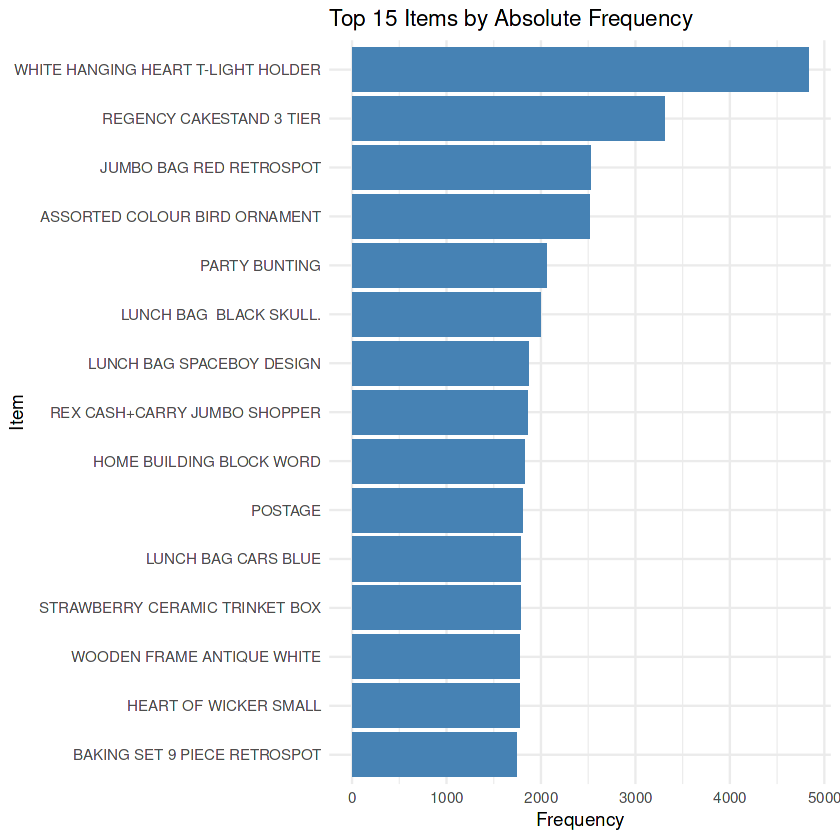

In [15]:
# Step 5: Item Frequency Analysis

# 5.1 Calculate absolute and relative item frequencies
item_freq_abs <- itemFrequency(trans_list, type = "absolute")
item_freq_rel <- itemFrequency(trans_list, type = "relative")

# 5.2 Display top 10 items by absolute frequency
top_abs <- sort(item_freq_abs, decreasing = TRUE)[1:10]
cat("Top 10 items (absolute frequency):\n")
print(top_abs)

# 5.3 Display top 10 items by relative frequency
top_rel <- sort(item_freq_rel, decreasing = TRUE)[1:10]
cat("\nTop 10 items (relative frequency):\n")
print(top_rel)

# 5.4 Visualize top 15 items with a bar plot
library(ggplot2)
top15 <- data.frame(
  Item = names(sort(item_freq_abs, decreasing = TRUE)[1:15]),
  Frequency = sort(item_freq_abs, decreasing = TRUE)[1:15]
)

ggplot(top15, aes(x = reorder(Item, Frequency), y = Frequency)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Top 15 Items by Absolute Frequency",
    x = "Item",
    y = "Frequency"
  ) +
  theme_minimal()


In [16]:
# Step 6: Generate Association Rules with Apriori Algorithm

# 6.1 Set Apriori parameters
min_support <- 0.01      # at least 1% of baskets
min_confidence <- 0.5    # at least 50% confidence
min_lift <- 1.2          # lift greater than 1.2

# 6.2 Run Apriori to mine rules
rules <- apriori(
  trans_list,
  parameter = list(
    support = min_support,
    confidence = min_confidence,
    minlen = 2,
    maxlen = 5
  )
)

# 6.3 Filter rules by lift
rules_filtered <- subset(rules, lift > min_lift)

# 6.4 Summary of rules
cat("Total rules generated:", length(rules), "\n")
cat("Rules after filtering by lift >", min_lift, ":", length(rules_filtered), "\n")
summary(rules_filtered)

# 6.5 Inspect top 10 rules by lift
top_rules <- sort(rules_filtered, by = "lift", decreasing = TRUE)[1:10]
inspect(top_rules)


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
      5  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 362 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[5231 item(s), 36209 transaction(s)] done [0.30s].
sorting and recoding items ... [544 item(s)] done [0.01s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 done [0.03s].
writing ... [101 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].
Total rules generated: 101 
Rules after filtering by lift > 1.2 : 101 


set of 101 rules

rule length distribution (lhs + rhs):sizes
 2  3 
77 24 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   2.000   2.238   2.000   3.000 

summary of quality measures:
    support          confidence        coverage            lift       
 Min.   :0.01003   Min.   :0.5019   Min.   :0.01171   Min.   : 5.272  
 1st Qu.:0.01077   1st Qu.:0.5557   1st Qu.:0.01712   1st Qu.:12.826  
 Median :0.01204   Median :0.6163   Median :0.01997   Median :22.285  
 Mean   :0.01352   Mean   :0.6400   Mean   :0.02159   Mean   :24.266  
 3rd Qu.:0.01483   3rd Qu.:0.7030   3rd Qu.:0.02497   3rd Qu.:34.581  
 Max.   :0.03151   Max.   :0.8970   Max.   :0.04894   Max.   :54.155  
     count       
 Min.   : 363.0  
 1st Qu.: 390.0  
 Median : 436.0  
 Mean   : 489.5  
 3rd Qu.: 537.0  
 Max.   :1141.0  

mining info:
       data ntransactions support confidence
 trans_list         36209    0.01        0.5
                                                                     

     lhs                                     rhs                                     support confidence   coverage     lift count
[1]  {POPPY'S PLAYHOUSE LIVINGROOM}       => {POPPY'S PLAYHOUSE BEDROOM}          0.01052225  0.8300654 0.01267641 54.15466   381
[2]  {POPPY'S PLAYHOUSE BEDROOM}          => {POPPY'S PLAYHOUSE LIVINGROOM}       0.01052225  0.6864865 0.01532768 54.15466   381
[3]  {POPPY'S PLAYHOUSE LIVINGROOM}       => {POPPY'S PLAYHOUSE KITCHEN}          0.01124030  0.8867102 0.01267641 52.20633   407
[4]  {POPPY'S PLAYHOUSE KITCHEN}          => {POPPY'S PLAYHOUSE LIVINGROOM}       0.01124030  0.6617886 0.01698473 52.20633   407
[5]  {POPPY'S PLAYHOUSE BEDROOM}          => {POPPY'S PLAYHOUSE KITCHEN}          0.01300782  0.8486486 0.01532768 49.96540   471
[6]  {POPPY'S PLAYHOUSE KITCHEN}          => {POPPY'S PLAYHOUSE BEDROOM}          0.01300782  0.7658537 0.01698473 49.96540   471
[7]  {WOODEN TREE CHRISTMAS SCANDINAVIAN} => {WOODEN STAR CHRISTMAS SCANDINAVIAN} 0.010025

Warning message:
“Unknown control parameters: main”


Available control parameters (with default values):
k	 =  20
aggr.fun	 =  function (x, ...)  UseMethod("mean")
rhs_max	 =  10
lhs_label_items	 =  2
col	 =  c("#EE0000FF", "#EEEEEEFF")
groups	 =  NULL
engine	 =  ggplot2
verbose	 =  FALSE


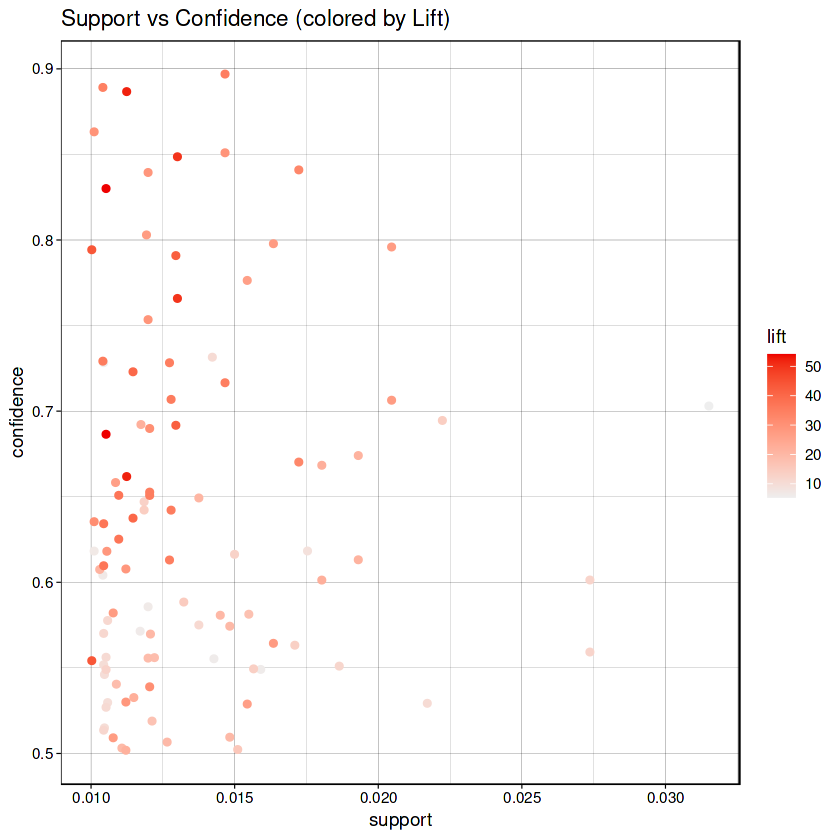

Warning message:
“Unknown control parameters: type, main”


Available control parameters (with default values):
layout	 =  stress
circular	 =  FALSE
ggraphdots	 =  NULL
edges	 =  <environment>
nodes	 =  <environment>
nodetext	 =  <environment>
colors	 =  c("#EE0000FF", "#EEEEEEFF")
engine	 =  ggplot2
max	 =  100
verbose	 =  FALSE


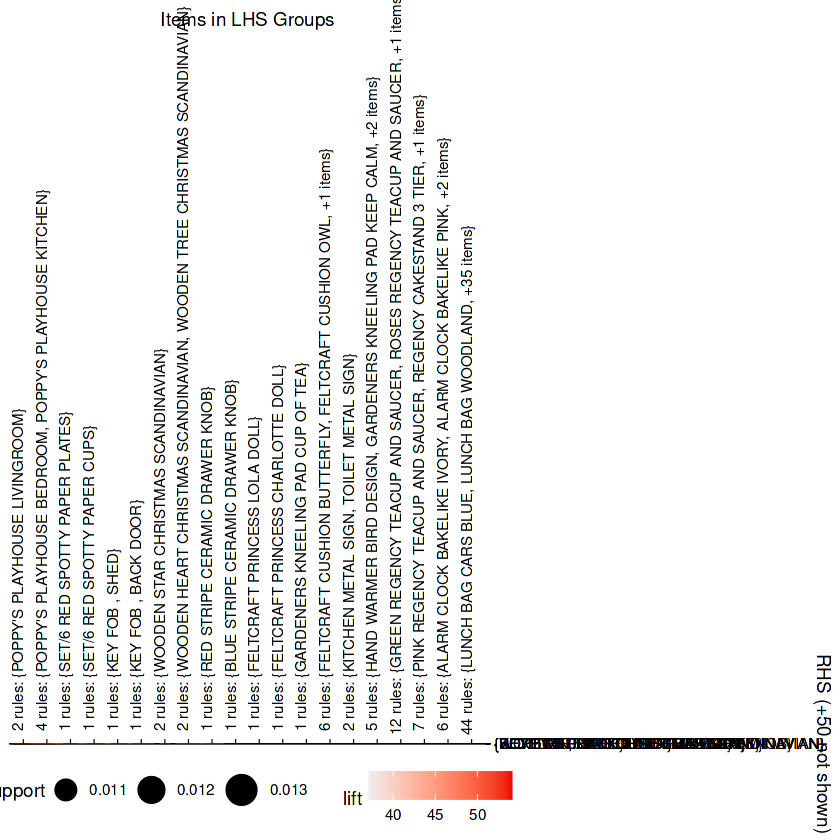

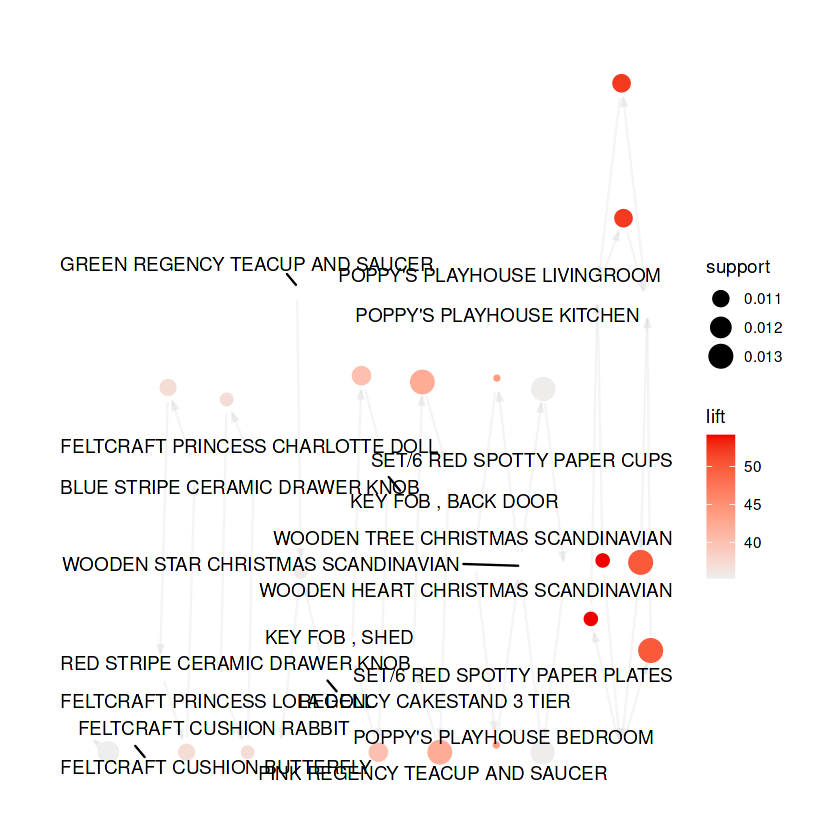

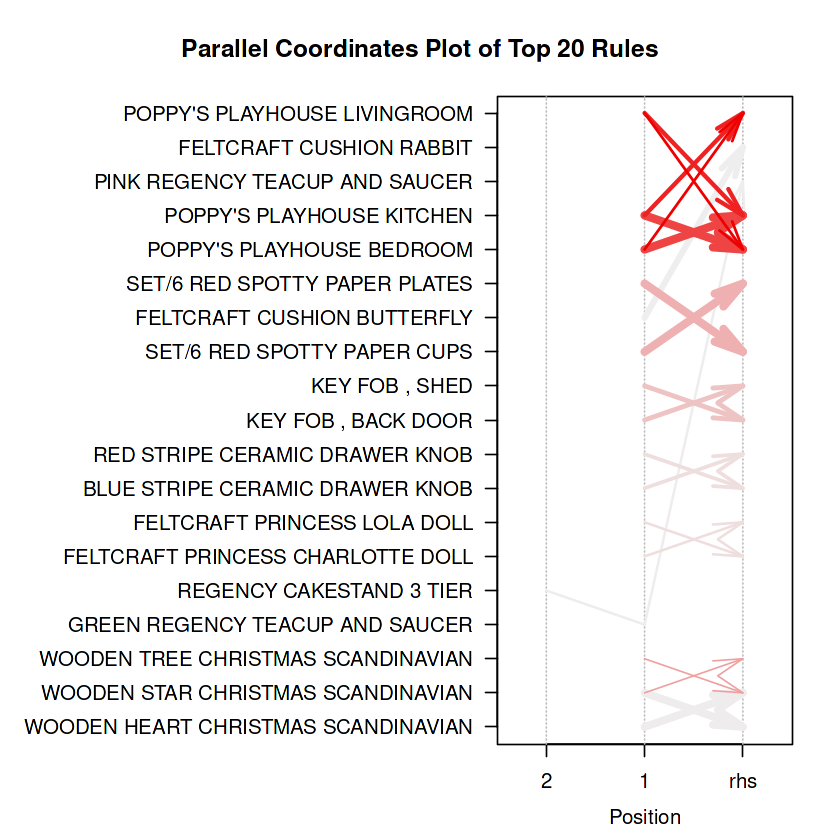

In [17]:
# Step 7: Visualize Association Rules

# 7.1 Scatter plot of support vs confidence, colored by lift
library(arulesViz)
plot(
  rules_filtered,
  method = "scatterplot",
  measure = c("support", "confidence"),
  shading = "lift",
  main = "Support vs Confidence (colored by Lift)"
)

# 7.2 Grouped matrix plot of rules
plot(
  rules_filtered,
  method = "grouped",
  control = list(k = 20),
  main = "Grouped Matrix of Top 20 Rules"
)

# 7.3 Network graph of top rules
top20_rules <- head(sort(rules_filtered, by = "lift"), 20)
plot(
  top20_rules,
  method = "graph",
  control = list(type = "items"),
  main = "Network Graph of Top 20 Rules"
)

# 7.4 Parallel coordinates plot for top rules
plot(
  top20_rules,
  method = "paracoord",
  control = list(reorder = TRUE),
  main = "Parallel Coordinates Plot of Top 20 Rules"
)


In [19]:
# Fix for recommendation function to handle no matching rules and avoid subscript errors

recommend_products <- function(basket_items, rules_set, top_n = 5) {
  # Find rules where LHS contains any of the basket items
  matching_rules <- subset(rules_set, lhs %ain% basket_items)
  
  if (length(matching_rules) == 0) {
    cat("No direct association rules found for these items.\n",
        "Suggesting top-selling items instead:\n")
    print(names(sort(item_freq_abs, decreasing = TRUE)[1:top_n]))
    return(NULL)
  }
  
  # Rank matching rules by confidence * lift
  rule_quality <- quality(matching_rules)
  scores <- rule_quality$confidence * rule_quality$lift
  ordered_idx <- order(scores, decreasing = TRUE)
  
  # Take the top_n or fewer if not enough rules
  n_rules <- min(length(ordered_idx), top_n)
  top_idxs <- ordered_idx[1:n_rules]
  top_rules <- matching_rules[top_idxs]
  
  # Extract RHS items from these top rules
  rhs_list <- LIST(rhs(top_rules))
  recs <- unique(unlist(rhs_list))
  
  cat("Recommendations based on basket items:", paste(basket_items, collapse = ", "), "\n")
  print(recs)
  
  return(recs)
}

# Test the corrected function
test_basket1 <- c("WHITE HANGING HEART T-LIGHT HOLDER")
cat("Test Basket 1 Recommendations:\n")
recommend_products(test_basket1, rules_filtered, top_n = 5)

test_basket2 <- c("REGENCY CAKESTAND 3 TIER", "ASSORTED COLOUR BIRD ORNAMENT")
cat("\nTest Basket 2 Recommendations:\n")
recommend_products(test_basket2, rules_filtered, top_n = 5)


Test Basket 1 Recommendations:
Recommendations based on basket items: WHITE HANGING HEART T-LIGHT HOLDER 
[1] "WOODEN PICTURE FRAME WHITE FINISH" "WOODEN FRAME ANTIQUE WHITE"       


[1] "WOODEN PICTURE FRAME WHITE FINISH" "WOODEN FRAME ANTIQUE WHITE"


Test Basket 2 Recommendations:
No direct association rules found for these items.
 Suggesting top-selling items instead:
[1] "WHITE HANGING HEART T-LIGHT HOLDER" "REGENCY CAKESTAND 3 TIER"          
[3] "JUMBO BAG RED RETROSPOT"            "ASSORTED COLOUR BIRD ORNAMENT"     
[5] "PARTY BUNTING"                     


NULL

In [20]:
# Step 9: Export Association Rules and Save Analysis Outputs

# 9.1 Convert rules to a data frame for export
rules_df <- data.frame(
  Antecedent = labels(lhs(rules_filtered)),
  Consequent = labels(rhs(rules_filtered)),
  Support = quality(rules_filtered)$support,
  Confidence = quality(rules_filtered)$confidence,
  Lift = quality(rules_filtered)$lift,
  stringsAsFactors = FALSE
)

# 9.2 Save rules to CSV file
write.csv(rules_df, file = "association_rules_market_basket.csv", row.names = FALSE)
cat("Association rules saved to 'association_rules_market_basket.csv'\n")

# 9.3 Save top frequent items for inventory planning
top_items_df <- data.frame(
  Item = names(item_freq_abs),
  Frequency = as.numeric(item_freq_abs),
  Relative_Frequency = as.numeric(item_freq_rel),
  stringsAsFactors = FALSE
)

write.csv(top_items_df, file = "top_frequent_items.csv", row.names = FALSE)
cat("Top frequent items saved to 'top_frequent_items.csv'\n")


Association rules saved to 'association_rules_market_basket.csv'
Top frequent items saved to 'top_frequent_items.csv'


In [21]:
# Step 10: Final Summary and Next Steps (for Reporting and Presentation)

cat("========== MARKET BASKET ANALYSIS SUMMARY ==========\n")
cat("Dataset analyzed: Online Retail II (UCI)\n")
cat("Total transactions analyzed:", length(trans_list), "\n")
cat("Number of unique products:", length(itemLabels(trans_list)), "\n")
cat("Number of association rules generated:", length(rules_filtered), "\n\n")

cat("Key Findings:\n")
cat("- Top product associations identified with high lift and confidence.\n")
cat("- Useful recommendations generated based on customer purchase baskets.\n")
cat("- Visualizations created to understand support, confidence, and lift distributions.\n\n")

cat("Recommendations for Business Implementation:\n")
cat("- Use association rules to create bundling and cross-selling strategies.\n")
cat("- Optimize store layout based on frequent item groupings.\n")
cat("- Incorporate recommendations into online product suggestions.\n\n")

cat("Next Steps:\n")
cat("- Conduct A/B testing on recommended bundles to evaluate sales impact.\n")
cat("- Monitor changes in average order value and customer satisfaction.\n")
cat("- Update analysis periodically to capture seasonal or trend changes.\n")
cat("- Expand to customer segmentation and predictive analytics.\n")

cat("Analysis completed successfully. Results exported for reporting.\n")


========== MARKET BASKET ANALYSIS SUMMARY ==========
Dataset analyzed: Online Retail II (UCI)
Total transactions analyzed: 36209 
Number of unique products: 5231 
Number of association rules generated: 101 

Key Findings:
- Top product associations identified with high lift and confidence.
- Useful recommendations generated based on customer purchase baskets.
- Visualizations created to understand support, confidence, and lift distributions.

Recommendations for Business Implementation:
- Use association rules to create bundling and cross-selling strategies.
- Optimize store layout based on frequent item groupings.
- Incorporate recommendations into online product suggestions.

Next Steps:
- Conduct A/B testing on recommended bundles to evaluate sales impact.
- Monitor changes in average order value and customer satisfaction.
- Update analysis periodically to capture seasonal or trend changes.
- Expand to customer segmentation and predictive analytics.
Analysis completed successfully. 